## 二分类逻辑回归案例 ##

## 构造数据集 ##

每行为一个对象，每列为一个特征属性，第1列为x1，第2列为x2，最后一列为所属分类。

```
data=[
    [-0.017612,14.053064,0],
	[-0.752157,6.538620,0],
	[-1.322371,7.152853,0],
	[0.423363,11.054677,0],
	[0.569411,9.548755,0],
	[-0.026632,10.427743,0],
	[0.667394,12.741452,0],
	[1.347183,13.175500,0],
	[1.217916,9.597015,0],
	[-0.733928,9.098687,0],
	[1.416614,9.619232,0],
	[1.388610,9.341997,0],
	[0.317029,14.739025,0],
	[-0.576525,11.778922,0],
	[-1.781871,9.097953,0],
	[-1.395634,4.662541,1],
	[0.406704,7.067335,1],
	[-2.460150,6.866805,1],
	[0.850433,6.920334,1],
	[1.176813,3.167020,1],
	[-0.566606,5.749003,1],
	[0.931635,1.589505,1],
	[-0.024205,6.151823,1],
	[-0.036453,2.690988,1],
	[-0.196949,0.444165,1],
	[1.014459,5.754399,1],
	[1.985298,3.230619,1],
	[-1.693453,-0.557540,1],
	[-0.346811,-1.678730,1],
	[-2.124484,2.672471,1]
]
```

In [2]:
data=[
    [-0.017612,14.053064,0],
	[-0.752157,6.538620,0],
	[-1.322371,7.152853,0],
	[0.423363,11.054677,0],
	[0.569411,9.548755,0],
	[-0.026632,10.427743,0],
	[0.667394,12.741452,0],
	[1.347183,13.175500,0],
	[1.217916,9.597015,0],
	[-0.733928,9.098687,0],
	[1.416614,9.619232,0],
	[1.388610,9.341997,0],
	[0.317029,14.739025,0],
	[-0.576525,11.778922,0],
	[-1.781871,9.097953,0],
	[-1.395634,4.662541,1],
	[0.406704,7.067335,1],
	[-2.460150,6.866805,1],
	[0.850433,6.920334,1],
	[1.176813,3.167020,1],
	[-0.566606,5.749003,1],
	[0.931635,1.589505,1],
	[-0.024205,6.151823,1],
	[-0.036453,2.690988,1],
	[-0.196949,0.444165,1],
	[1.014459,5.754399,1],
	[1.985298,3.230619,1],
	[-1.693453,-0.557540,1],
	[-0.346811,-1.678730,1],
	[-2.124484,2.672471,1]
]

先将数据集转化为逻辑分类可以处理的数据结构。即，为对象添加值为1的属性x0，将输出分类转换为one-hot编码。

In [3]:
#加载数据集，最后一列最为类别标签，前面的为特征属性的值
def loadDataSet(datasrc):
    dataMat = np.mat(datasrc)
    y = dataMat[:, dataMat.shape[1] - 1]  # 最后一列为结果列
    b = np.ones(y.shape)  # 添加全1列向量代表b偏量
    X = np.column_stack((b, dataMat[:, 0:dataMat.shape[1] - 1]))  # 特征属性集和b偏量组成x
    X = np.mat(X)
    labeltype = np.unique(y.tolist())  # 获取分类数目
    eyes = np.eye(len(labeltype))  # 每一类用单位矩阵中对应的行代替，表示目标概率。如分类0的概率[1,0,0]，分类1的概率[0,1,0]，分类2的概率[0,0,1]
    Y = np.zeros((X.shape[0], len(labeltype)))
    for i in range(X.shape[0]):
        Y[i, :] = eyes[int(y[i, 0])]  # 读取分类，替换成概率向量。这就要求分类为0,1,2,3,4,5这样的整数
    # print(Y)
    return X, y, Y  # X为特征数据集，y为分类数据集，Y为概率集

我们先来看看数据是个什么样子

In [4]:
#可视化样本数据集
def plotDataSet():
    dataMat,labelMat,labelPMat = loadDataSet(data)                        #加载数据集
    plt.scatter(dataMat[:,1].flatten().A[0],dataMat[:,2].flatten().A[0],c=labelMat.flatten().A[0])                   #第一个偏量为b，第2个偏量x1，第3个偏量x2
    plt.xlabel('X1'); plt.ylabel('X2')                                 #绘制label
    plt.xlim([-3,3])
    plt.ylim([-4,16])
    plt.show()

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/69c8b1c9caaf439ae40836bab4ab6f73.png)

我们使用的样本数据，有两个特征属性，x1和x2如果，算上b偏量就是三个回归系数。结果为2分类。

则线性函数的输出结果为[z0,z1]

z0=w00*1 + w01*x1 + w02*x2
z1=w10*1 + w11*x1 + w12*x2

线性函数的结果[z0,z1]再经过Sigmoid激活函数，可得到预测的分类概率[y0,y1]。

当然最开始这个预测的分类概率并不准确，所以需要模型训练，不停的根据预测的结果是否准确来调整回归系数。

其中Sigmoid逻辑回归函数实现如下：


In [5]:
# sigmoid函数，逻辑回归函数，将线性回归值转化为概率的激活函数
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

## 梯度下降法获取回归系数： ##

在逻辑回归中，梯度下降法的更新公式为

$w_{k+1}=w_k-\rho  \nabla J(w_k)=w_k-\rho  X^T(sigmoid(Xw_k)-y)$


按照这个公式实现代码

In [7]:
# 逻辑回归中使用梯度下降法求回归系数。逻辑回归和线性回归中原理相同，只不过逻辑回归使用sigmoid作为迭代进化函数。因为逻辑回归是为了分类而生。线性回归为了预测而生
def gradAscent(dataMat, labelPMat):
    m, n = np.shape(dataMat)                                            #返回dataMatrix的大小。m为行数,n为列数。
    alpha = 0.05                                                        #移动步长,也就是学习速率,控制更新的幅度。
    maxCycles = 1000                                                      #最大迭代次数
    weights = np.ones((n,labelPMat.shape[1]))                                             #初始化权重列向量
    for k in range(maxCycles):
        h =  sigmoid(dataMat * weights)                                #梯度上升矢量化公式，计算预测值（列向量）。每一个样本产生一个预测值
        error = h-labelPMat                                            #计算每一个样本预测值误差
        weights = weights - alpha * dataMat.T * error                   # 根据所有的样本产生的误差调整回归系数
    return weights.getA()                                               # 将矩阵转换为数组，返回回归系数数组

绘制分类区域

[[-25.59438046  25.59391839]
 [ -0.98397956   0.98400217]
 [  3.78622424  -3.78617333]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


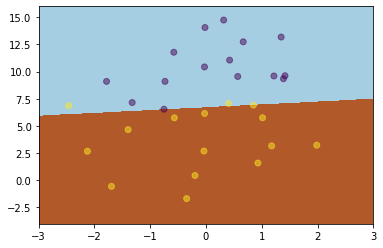

In [10]:
# 分类只能绘制分界区域。而不是通过分割线来可视化
def plotBestFit(dataMat,labelMat,weights):

    # 先产生x1和x2取值范围上的网格点，并预测每个网格点上的值。
    step = 0.02
    x1_min, x1_max = -3,3
    x2_min, x2_max = -4,16
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))
    testMat = np.c_[xx1.ravel(), xx2.ravel()]   #形成测试特征数据集
    testMat = np.column_stack((np.ones(((testMat.shape[0]),1)),testMat))  #添加第一列为全1代表b偏量
    testMat = np.mat(testMat)
    y = sigmoid(testMat*weights)   #输出每个样本属于每个分类的概率
    predicted = y.argmax(axis=1)                            #获取每行最大值的位置，位置索引就是分类
    predicted = predicted.reshape(xx1.shape).getA()
    # 绘制区域网格图
    plt.pcolormesh(xx1, xx2, predicted, cmap=plt.cm.Paired)

    # 再绘制一遍样本数据点，这样方便查看
    plt.scatter(dataMat[:, 1].flatten().A[0], dataMat[:, 2].flatten().A[0],
                c=labelMat.flatten().A[0], alpha=.5)  # 第一个偏量为b，第2个偏量x1，第3个偏量x2
    plt.xlim([-3,3])
    plt.ylim([-4,16])
    plt.show()

if __name__ == '__main__':
    import numpy as np;
    import matplotlib.pyplot as plt ;
    dataMat, labelMat, labelPMat = loadDataSet(data)   # 加载数据集
    weights = gradAscent(dataMat, labelPMat)         # 梯度下降法求回归系数
    print(weights)

    plotBestFit(dataMat,labelMat,weights)

回归系数矩阵w为：

[[-25.38603398  25.43723638]
 [ -3.98349475   3.99351765]
 [  3.60847635  -3.61579463]]

绘制出的分割区域为

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/489b27990fbc4b75d75a27d59255ac52.png)


## 随机梯度下降法获取回归系数： ##

在逻辑回归中，随机梯度下降法的更新公式为

$w_{k+1}=w_k-\rho_kx_k^T(sigmoid(x_kw_k)-y_k)$

其中$x_k$为一个样本对象（行向量），$y_k$为该对象的输出（行向量）。


In [11]:
# 逻辑回归中使用随机梯度下降算法。numIter为迭代次数。改进之处：alpha移动步长是变化的。一次只用一个样本点去更新回归系数，这样就可以有效减少计算量了
def stocGradAscent(dataMatrix, labelPMat, numIter=500):
    m,n = np.shape(dataMatrix)                                                #返回dataMatrix的大小。m为样本对象的数目,n为列数。
    weights = np.ones((n,labelPMat.shape[1]))                                                  #参数初始化
    for j in range(numIter):
        for k in range(m):                                                    # 遍历m个样本对象
            alpha = 10/(1.0+j+k)+0.01                                          #降低alpha的大小，每次减小1/(j+i)。刚开始的时候可以步长大一点，后面调整越精细
            h = sigmoid(dataMatrix[k]*weights)                        #选择随机选取的一个样本，计算预测值h
            error = h-labelPMat[k]                              #计算一个样本的误差
            weights = weights - alpha * dataMatrix[k].T*error         #更新回归系数
    return weights.getA()                                                           #将矩阵转换为数组，返回回归系数数组

获取回归系数矩阵，绘制分割区域

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[[-23.02355894  24.91011965]
 [ -0.53497869   0.54390795]
 [  3.04863856  -3.31945114]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


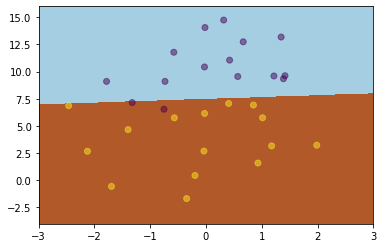

In [12]:
if __name__ == '__main__':
    dataMat, labelMat, labelPMat = loadDataSet(data)   # 加载数据集
    weights = stocGradAscent(dataMat, labelPMat)    # 局部梯度下降法求回归系数
    print(weights)
    plotBestFit(dataMat,labelMat,weights)

回归系数矩阵为：

[[-23.98429667  27.70302552]
 [ -3.8623706    4.56685091]
 [  3.36581925  -3.90760748]]


绘制出的分割区域为

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/7629975ef4706cca2b7fdf7d84101fbd.png)


# 对新对象进行预测

有了回归系数矩阵，就可以对逻辑回归问题进行分类了。


In [13]:
# 对新对象进行预测
def predict(weights,testdata):
    testdata.insert(0, 1.0)       #现在首部添加1代表b偏量
    testMat = np.mat([testdata])
    y=sigmoid(testMat * np.mat(weights))  # 对输入进行预测
    type = y.argmax(axis=1)  # 概率最大的分类就是预测分类。由于输出值y为行向量，所按行取最大值的位置
    return type, y  # type为所属分类，h为属于每种分类的概率


if __name__ == '__main__':
    dataMat, labelMat, labelPMat = loadDataSet(data)   # 加载数据集
    weights = gradAscent(dataMat, labelPMat)         # 梯度下降法求回归系数
    # weights = gradAscent(dataMat, labelPMat)         # 梯度下降法求回归系数
    print(weights)
    type,h = predict(weights,[0.317029,14.739025])
    print(type,h)

[[-25.59438046  25.59391839]
 [ -0.98397956   0.98400217]
 [  3.78622424  -3.78617333]]
[[0]] [[1.0000000e+00 1.0355974e-13]]


**输出分类和概率为**

[[0]] [[  1.00000000e+00   4.43767950e-13]]

表示输入对象[0.317029,14.739025]，属于分类0，因为属于分类0 的概率为1.0，属于分类1的概率为4.43767950e-13。

## 多分类softmax回归 ##

## 加载数据集 ##

数据集就采用如下的数据，和二分类的区别在于类别有三种：0，1，2。

样本数据集第一列为属性x1，第二列为属性x2，第三列为分类（三种类别）

In [14]:
# 样本数据集，第一列为x1，第二列为x2，第三列为分类（三种类别）
data=[
        [-2.68420713, 0.32660731, 0],[-2.71539062, -0.16955685, 0],[-2.88981954, -0.13734561, 0],[-2.7464372, -0.31112432, 0],[-2.72859298, 0.33392456, 0],
        [-2.27989736, 0.74778271, 0],[-2.82089068, -0.08210451, 0],[-2.62648199, 0.17040535, 0],[-2.88795857, -0.57079803, 0],[-2.67384469, -0.1066917, 0],
        [-2.50652679,0.65193501,0],[-2.61314272,0.02152063,0],[-2.78743398,-0.22774019,0],[-3.22520045,-0.50327991,0],[-2.64354322,1.1861949,0],
        [-2.38386932,1.34475434,0],[-2.6225262,0.81808967,0],[-2.64832273,0.31913667,0],[-2.19907796,0.87924409,0],[-2.58734619,0.52047364,0],
        [1.28479459, 0.68543919, 1],[0.93241075, 0.31919809, 1],[1.46406132, 0.50418983, 1],[0.18096721, -0.82560394, 1],[1.08713449, 0.07539039, 1],
        [0.64043675, -0.41732348, 1],[1.09522371, 0.28389121, 1],[-0.75146714, -1.00110751, 1],[1.04329778, 0.22895691, 1],[-0.01019007, -0.72057487, 1],
        [-0.5110862,-1.26249195,1],[0.51109806,-0.10228411,1],[0.26233576,-0.5478933,1],[0.98404455,-0.12436042,1],[-0.174864,-0.25181557,1],
        [0.92757294,0.46823621,1],[0.65959279,-0.35197629,1],[0.23454059,-0.33192183,1],[0.94236171,-0.54182226,1],[0.0432464,-0.58148945,1],
        [2.53172698, -0.01184224, 2],[1.41407223, -0.57492506, 2],[2.61648461, 0.34193529, 2],[1.97081495, -0.18112569, 2],[2.34975798, -0.04188255, 2],
        [3.39687992, 0.54716805, 2],[0.51938325, -1.19135169, 2],[2.9320051, 0.35237701, 2],[2.31967279, -0.24554817, 2],[2.91813423, 0.78038063, 2],
        [1.66193495,0.2420384,2],[1.80234045,-0.21615461,2],[2.16537886,0.21528028,2],[1.34459422,-0.77641543,2],[1.5852673,-0.53930705,2],
        [1.90474358,0.11881899,2],[1.94924878,0.04073026,2],[3.48876538,1.17154454,2],[3.79468686,0.25326557,2],[1.29832982,-0.76101394,2],
]

先将数据集转化为逻辑分类可以处理的数据结构。即，为对象添加值为1的属性x0，将输出分类转换为one-hot编码。

分类0表示为[1,0,0]，分类1表示为[0,1,0]，分类2表示为[0,0,1]

In [15]:
# 加载数据集，最后一列最为类别标签，前面的为特征属性的值
def loadDataSet(dataarr):
    # 生成X和y矩阵
    dataMat = np.mat(dataarr)
    y = dataMat[:, dataMat.shape[1] - 1]  # 最后一列为结果列
    b = np.ones(y.shape)  # 添加全1列向量代表b偏量
    X = np.column_stack((b, dataMat[:, 0:dataMat.shape[1] - 1]))  # 特征属性集和b偏量组成x
    X = np.mat(X)
    labeltype = np.unique(y.tolist())       # 获取分类数目
    eyes = np.eye(len(labeltype))    # 每一类用单位矩阵中对应的行代替，表示目标概率。如分类0的概率[1,0,0]，分类1的概率[0,1,0]，分类2的概率[0,0,1]
    Y=np.zeros((X.shape[0],len(labeltype)))
    for i in range(X.shape[0]):
        Y[i,:] = eyes[int(y[i,0])]               # 读取分类，替换成概率向量。这就要求分类为0,1,2,3,4,5这样的整数
    return X, y,Y       #X为特征数据集，y为分类数据集，Y为概率集

下面我们先来看看数据是什么样的。

In [16]:
#可视化样本数据集
def plotDataSet():
    dataMat,labelMat,labelPMat = loadDataSet()                        #加载数据集
    plt.scatter(dataMat[:,1].flatten().A[0],dataMat[:,2].flatten().A[0],c=labelMat.flatten().A[0])                   #第一个偏量为b，第2个偏量x1，第3个偏量x2
    plt.xlabel('X1'); plt.ylabel('X2')                                 #绘制label
    plt.show()

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/1d9ea5def2330138c4110d824c81b262.png)

## softmax回归的梯度下降法 ##

在softmax回归中，梯度下降法的更新公式为

$w_{k+1}=w_k-\rho  \nabla J(w_k)=w_k-\rho  X^T(softmax(Xw_k)-y)$

按照这个公式实现代码

In [17]:
# softmax函数，将线性回归值转化为概率的激活函数。输入s要是行向量
def softmax(s):
    return np.exp(s) / np.sum(np.exp(s), axis=1)

# 逻辑回归中使用梯度下降法求回归系数。逻辑回归和线性回归中原理相同，只不过逻辑回归使用sigmoid作为迭代进化函数。因为逻辑回归是为了分类而生。线性回归为了预测而生
def gradAscent(dataMat, labelPMat):
    alpha = 0.2                                                        #移动步长,也就是学习速率,控制更新的幅度。
    maxCycles = 1000                                                      #最大迭代次数
    weights = np.ones((dataMat.shape[1],labelPMat.shape[1]))             #初始化权回归系数矩阵  系数矩阵的行数为特征矩阵的列数，系数矩阵的列数为分类数目
    for k in range(maxCycles):
        h =  softmax(dataMat*weights)                                #梯度上升矢量化公式，计算预测值（行向量）。每一个样本产生一个概率行向量
        error = h-labelPMat                                            #计算每一个样本预测值误差
        weights = weights - alpha * dataMat.T * error                   # 根据所有的样本产生的误差调整回归系数
    return weights                                  

绘制分类区域

[[ -0.76478209  12.94845658  -9.18367448]
 [-10.22934766  -1.38818119  14.61752885]
 [  5.38500348   5.07899946  -7.46400295]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


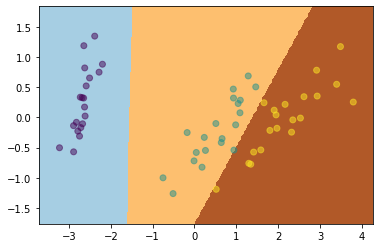

In [18]:
# 多分类只能绘制分界区域。而不是通过分割线来可视化
def plotBestFit(dataMat,labelMat,weights):

    # 获取数据边界值，也就属性的取值范围。
    x1_min, x1_max = dataMat[:, 1].min() - .5, dataMat[:, 1].max() + .5
    x2_min, x2_max = dataMat[:, 2].min() - .5, dataMat[:, 2].max() + .5
    # 产生x1和x2取值范围上的网格点，并预测每个网格点上的值。
    step = 0.02
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))
    testMat = np.c_[xx1.ravel(), xx2.ravel()]   #形成测试特征数据集
    testMat = np.column_stack((np.ones(((testMat.shape[0]),1)),testMat))  #添加第一列为全1代表b偏量
    testMat = np.mat(testMat)
    # 预测网格点上的值
    y = softmax(testMat*weights)   #输出每个样本属于每个分类的概率
    # 判断所属的分类
    predicted = y.argmax(axis=1)                            #获取每行最大值的位置，位置索引就是分类
    predicted = predicted.reshape(xx1.shape).getA()
    # 绘制区域网格图
    plt.pcolormesh(xx1, xx2, predicted, cmap=plt.cm.Paired)

    # 再绘制一遍样本点，方便对比查看
    plt.scatter(dataMat[:, 1].flatten().A[0], dataMat[:, 2].flatten().A[0],
                c=labelMat.flatten().A[0],alpha=.5)  # 第一个偏量为b，第2个偏量x1，第3个偏量x2
    plt.show()


if __name__ == '__main__':

    dataMat, labelMat,labelPMat = loadDataSet(data)  # 加载数据集
    # 梯度下降法
    weights = gradAscent(dataMat, labelPMat)         # 梯度下降法求回归系数
    print(weights)
    plotBestFit(dataMat,labelMat,weights)


**权重矩阵w为**

[[ -0.76478209  12.94845658  -9.18367448]

 [-10.22934766  -1.38818119  14.61752885]
 
 [  5.38500348   5.07899946  -7.46400295]]

**绘制的分割区域为**

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/b61c7de255e80866ccff4531e9c110c8.png)


## softmax回归的随机梯度下降法 ##

在softmax回归中，随机梯度下降法的更新公式为

$w_{k+1}=w_k-\rho_kx_k^T(softmax(x_kw_k)-y_k)$

按照这个公式实现代码

In [19]:
# 逻辑回归中使用随机梯度下降算法。numIter为迭代次数。改进之处：alpha移动步长是变化的。一次只用一个样本点去更新回归系数，这样就可以有效减少计算量了
def stocGradAscent(dataMatrix, labelPMat, numIter=500):
    m,n = np.shape(dataMatrix)                                                #返回dataMatrix的大小。m为样本对象的数目,n为列数。
    weights = np.ones((n,labelPMat.shape[1]))                                                  #参数初始化
    for j in range(numIter):
        for k in range(m):                                                    # 遍历m个样本对象
            alpha = 2/(1.0+j+k)+0.01                                          #降低alpha的大小，每次减小1/(j+i)。刚开始的时候可以步长大一点，后面调整越精细
            h = softmax(dataMatrix[k]*weights)                        #选择随机选取的一个样本，计算预测值h
            error = h-labelPMat[k]                              #计算一个样本的误差
            weights = weights - alpha * dataMatrix[k].T*error         #更新回归系数
    return weights.getA()                                                           #将矩阵转换为数组，返回回归系数数组

绘制分割区域

[[ 0.47984299  5.90667081 -3.3865138 ]
 [-4.05158015  0.15033584  6.90124431]
 [ 3.70276223  2.36204289 -3.06480512]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


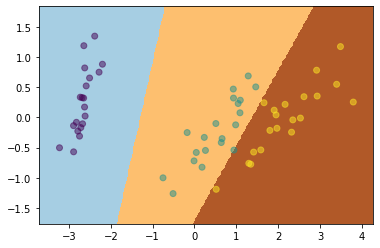

In [20]:
if __name__ == '__main__':

    dataMat, labelMat,labelPMat = loadDataSet(data)  # 加载数据集
    # 梯度下降法
    weights = stocGradAscent(dataMat, labelPMat)         # 梯度下降法求回归系数
    print(weights)
    plotBestFit(dataMat,labelMat,weights)

**得到的权重矩阵w为**

[[ -0.86015701   4.56667081  -4.7265138 ]

 [ -0.4547426    3.74717339  10.49808187]
 
 [  3.26510843   1.9243891   -3.50245892]]

**分割区域为**

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/0d8aeed4f07c29dd116f28942963e95e.png)

## 对新对象进行预测 ##

有了回归系数矩阵，就可以对softmax回归问题进行多分类了。

In [21]:
# 对新对象进行预测
def predict(weights,testdata):
    testdata.insert(0, 1.0)    #现在首部添加1代表b偏量
    testMat = np.mat([testdata])
    y=softmax(testMat * np.mat(weights))
    type = y.argmax(axis=1)   # 概率最大的分类就是预测分类。由于输出值y为行向量，所按行取最大值的位置
    return type,y   #type为所属分类，h为属于每种分类的概率



if __name__ == '__main__':
    dataMat, labelMat, labelPMat = loadDataSet(data)   # 加载数据集
    weights = gradAscent(dataMat, labelPMat)         # 梯度下降法求回归系数
    # weights = gradAscent(dataMat, labelPMat)         # 梯度下降法求回归系数
    print(weights)
    type,h = predict(weights,[1.90474358,0.11881899])
    print(type,h)

[[ -0.76478209  12.94845658  -9.18367448]
 [-10.22934766  -1.38818119  14.61752885]
 [  5.38500348   5.07899946  -7.46400295]]
[[2]] [[5.82158495e-17 1.04332831e-03 9.98956672e-01]]


**输出分类和概率为**

[[2]] [[  8.81398647e-08   5.11371774e-02   9.48862734e-01]]

表示输入对象[1.90474358,0.11881899]，属于分类2，因为属于分类0 的概率为8.81398647e-08，属于分类1的概率为5.11371774e-02，属于分类2的概率为 9.48862734e-01。

# 其他方式的编码

在逻辑回归中，二分类0和1一般要按one-hot编码成[1,0]和[0,1]。

我们知道[1,0]表示的是样本对象100%的概率为分类0，0%的概率为分类1

[0,1]表示的是样本对象0%的概率为分类0，100%的概率为分类1

---

那我们现在来尝试一下其他的概率表达方式：

比如二分类中，分类0是我想要的，分类1不是我想要的。

分类0的值表达成[100%]，表示100%是我想要的，

分类1的值表达成[0%]，表示0%是我想要的。

我们按照逻辑回归计算出来的概率值就是y只有一个值。这个值表达的是，是我想要的分类的概率，也就是该对象是分类0的概率。这个概率超过50%，我们就可以把他划分为分类0，低于50%，我们就可以划分为分类1。


由于我们使用这种方式进行编码，只计算一个输出值，
所以要计算的回归系数矩阵，就变成了

$$
        \begin{matrix}
        w0   \\
        w1  \\
        w2 \\
        \end{matrix}
$$

而不再是

$$
        \begin{matrix}
        w00 & w01  \\
        w10 & w11  \\
        w20 & w21  \\
        \end{matrix}
$$


实现代码为

[[-25.33705122]
 [ -3.97390641]
 [  3.60147525]]
1 [[1.]]


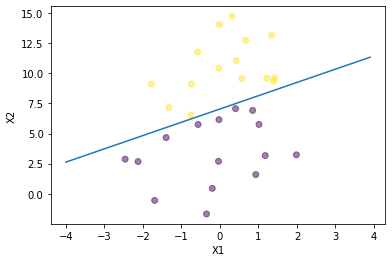

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random


# 样本数据集，第一列为x1，第二列为x2，第三列为分类（二种类别）,必须用0和1表示分类
data=[
    [-0.017612, 14.053064, 0],[-0.752157, 6.538620, 0],[-1.322371, 7.152853, 0],[0.423363, 11.054677, 0],[0.569411, 9.548755, 0],
    [-0.026632, 10.427743, 0],[0.667394, 12.741452, 0],[1.347183, 13.175500, 0],[1.217916, 9.597015, 0],[-0.733928, 9.098687, 0],
    [1.416614, 9.619232, 0],[1.388610, 9.341997, 0],[0.317029, 14.739025, 0],[-0.576525, 11.778922, 0],[-1.781871, 9.097953, 0],
    [-1.395634, 4.662541, 1],[0.406704, 7.067335, 1],[-2.460150, 2.866805, 1],[0.850433, 6.920334, 1],[1.176813, 3.167020, 1],
    [-0.566606, 5.749003, 1],[0.931635, 1.589505, 1],[-0.024205, 6.151823, 1],[-0.036453, 2.690988, 1],[-0.196949, 0.444165, 1],
    [1.014459, 5.754399, 1],[1.985298, 3.230619, 1],[-1.693453, -0.557540, 1],[-0.346811, -1.678730, 1],[-2.124484, 2.672471, 1]
]


#加载数据集，最后一列最为类别标签，前面的为特征属性的值
def loadDataSet(datasrc):
    dataMat = np.mat(datasrc)
    y = dataMat[:, dataMat.shape[1] - 1]  # 最后一列为结果列
    b = np.ones(y.shape)  # 添加全1列向量代表b偏量
    X = np.column_stack((b, dataMat[:, 0:dataMat.shape[1] - 1]))  # 特征属性集和b偏量组成x
    X = np.mat(X)
    for i in range(y.shape[0]):
        if y[i]==1:y[i]=0.0             # 分类1不是我想要的分类，所以概率写成0.0
        elif y[i] == 0: y[i] = 1.0     # 分类0是我想要的分类，所以概率写成1.0
    y=np.mat(y)
    return X, y  # X为特征数据集，y为分类数据集，Y为概率集



#可视化样本数据集
def plotDataSet():
    dataMat,labelMat,labelPMat = loadDataSet(data)                        #加载数据集
    plt.scatter(dataMat[:,1].flatten().A[0],dataMat[:,2].flatten().A[0],c=labelMat.flatten().A[0])                   #第一个偏量为b，第2个偏量x1，第3个偏量x2
    plt.xlabel('X1'); plt.ylabel('X2')                                 #绘制label
    plt.xlim([-3,3])
    plt.ylim([-4,16])
    plt.show()

# sigmoid函数，逻辑回归函数，将线性回归值转化为概率的激活函数
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

# 逻辑回归中使用梯度下降法求回归系数。逻辑回归和线性回归中原理相同，只不过逻辑回归使用sigmoid作为迭代进化函数。因为逻辑回归是为了分类而生。线性回归为了预测而生
def gradAscent(dataMat, labelPMat):
    m, n = np.shape(dataMat)                                            #返回dataMatrix的大小。m为行数,n为列数。
    alpha = 0.05                                                        #移动步长,也就是学习速率,控制更新的幅度。
    maxCycles = 1000                                                      #最大迭代次数
    weights = np.ones((n,1))                                             #初始化权重列向量
    for k in range(maxCycles):
        h =  sigmoid(dataMat * weights)                                #梯度上升矢量化公式，计算预测值（列向量）。每一个样本产生一个预测值
        error = h-labelPMat                                            #计算每一个样本预测值误差
        weights = weights - alpha * dataMat.T * error                   # 根据所有的样本产生的误差调整回归系数
    return weights.getA()                                               # 将矩阵转换为数组，返回回归系数数组

# 逻辑回归中使用随机梯度下降算法。numIter为迭代次数。改进之处：alpha移动步长是变化的。一次只用一个样本点去更新回归系数，这样就可以有效减少计算量了
def stocGradAscent(dataMatrix, labelMat, numIter=500):
    m,n = np.shape(dataMatrix)                                                #返回dataMatrix的大小。m为样本对象的数目,n为列数。
    weights = np.ones((n,1))                                                  #参数初始化
    for j in range(numIter):
        for k in range(m):                                                    # 遍历m个样本对象
            alpha = 10/(1.0+j+k)+0.01                                          #降低alpha的大小，每次减小1/(j+i)。刚开始的时候可以步长大一点，后面调整越精细
            h = sigmoid(dataMatrix[k]*weights)                        #选择随机选取的一个样本，计算预测值h
            error = h-labelMat[k]                              #计算一个样本的误差
            weights = weights - alpha * dataMatrix[k].T*error         #更新回归系数
    return weights.getA()                                                           #将矩阵转换为数组，返回回归系数数组


# 对新对象进行预测
def predict1(weights,testdata):
    testdata.insert(0, 1.0)       #现在首部添加1代表b偏量
    testMat = np.mat([testdata])
    z = testMat * np.mat(weights)
    y=sigmoid(z)
    if y>0.5:
    # if z>0:    #h>0.5的判断等价于  z>0
        return 1,y
    else:
        return 0,y



# 绘制分界线。
def plotBestFit(dataMat,labelMat,weights):
    plt.scatter(dataMat[:, 1].flatten().A[0], dataMat[:, 2].flatten().A[0],
                c=labelMat.flatten().A[0],alpha=.5)  # 第一个偏量为b，第2个偏量x1，第3个偏量x2

    x1 = np.arange(-4.0, 4.0, 0.1)
    x2 = (-weights[0] - weights[1] * x1) / weights[2]    # 逻辑回归获取的回归系数，满足w0+w1*x1+w2*x2=0，即x2 =(-w0-w1*x1)/w2
    plt.plot(x1, x2)
    plt.xlabel('X1'); plt.ylabel('X2')                                    #绘制label
    plt.show()



if __name__ == '__main__':
    # 查看数据集的分布
    # plotDataSet()

    dataMat, labelMat = loadDataSet(data)   # 加载数据集
    weights = gradAscent(dataMat, labelMat)         # 梯度下降法求回归系数
    # weights = stocGradAscent(dataMat, labelMat)    # 局部梯度下降法求回归系数
    print(weights)
    type,y = predict1(weights,[0.317029,14.739025])
    print(type,y)
    plotBestFit(dataMat,labelMat,weights)

**运行函数得到的回归系数为**

[[-23.98429667]

 [ -3.8623706 ]
 
 [  3.36581925]]

这个回归系数矩阵表达式是y=sigmoid(xw)中的w。

我们通过y>0.5进行分类判别。由于sigmoid是调单递增的。所以判别也就等价于xw>0。

将这个公式展开。

$1*w0+x1*w1+x2*w2>0$

将训练迭代的系数带入公式，

$1*-23.98429667+x1*-3.8623706+x2*3.36581925>0$

**下图绘制出了这条边界线。**

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/d1c6255c5fffd835fcdef874f68de957.png)


逻辑回归LR的特征为什么要先离散化
-----------------
在工业界，很少直接将连续值作为特征喂给逻辑回归模型，而是将连续特征离散化为一系列0、1特征交给逻辑回归模型，这样做的优势有以下几点：

0、离散特征的增加和减少都很容易，易于模型的快速迭代；

1、稀疏向量内积乘法运算速度快，计算结果方便存储，容易扩展；

2、离散化后的特征对异常数据有很强的鲁棒性：比如一个特征是年龄>30是1，否则0。如果特征没有离散化，一个异常数据“年龄300岁”会给模型造成很大的干扰；

3、逻辑回归属于广义线性模型，表达能力受限；单变量离散化为N个后，每个变量有单独的权重，相当于为模型引入了非线性，能够提升模型表达能力，加大拟合；

4、离散化后可以进行特征交叉，由M+N个变量变为M*N个变量，进一步引入非线性，提升表达能力；

5、特征离散化后，模型会更稳定，比如如果对用户年龄离散化，20-30作为一个区间，不会因为一个用户年龄长了一岁就变成一个完全不同的人。当然处于区间相邻处的样本会刚好相反，所以怎么划分区间是门学问；

6、特征离散化以后，起到了简化了逻辑回归模型的作用，降低了模型过拟合的风险。

```
李沐少帅指出，模型是使用离散特征还是连续特征，其实是一个“海量离散特征+简单模型” 同 “少量连续特征+复杂模型”的权衡。

既可以离散化用线性模型，也可以用连续特征加深度学习。就看是喜欢折腾特征还是折腾模型了。

通常来说，前者容易，而且可以n个人一起并行做，有成功经验；后者目前看很赞，能走多远还须拭目以待。
```

大概的理解：

1）计算简单

2）简化模型

3）增强模型的泛化能力，不易受噪声的影响

# 并行LR的实现

由逻辑回归问题的求解方法中可以看出，无论是梯度下降法、牛顿法、拟牛顿法，计算梯度都是其最基本的步骤，并且L-BFGS通过两步循环计算牛顿方向的方法，避免了计算海森矩阵。

因此逻辑回归的并行化最主要的就是对目标函数梯度计算的并行化。

从公式(2)中可以看出，目标函数的梯度向量计算中只需要进行向量间的点乘和相加，可以很容易将每个迭代过程拆分成相互独立的计算步骤，由不同的节点进行独立计算，然后归并计算结果。


将M个样本的标签构成一个M维的标签向量，M个N维特征向量构成一个M*N的样本矩阵

如果将样本矩阵按行划分，将样本特征向量分布到不同的计算节点，由各计算节点完成自己所负责样本的点乘与求和计算，然后将计算结果进行归并，则实现了“按行并行的LR”。

按行并行的LR解决了样本数量的问题，但是实际情况中会存在针对高维特征向量进行逻辑回归的场景（如广告系统中的特征维度高达上亿），仅仅按行进行并行处理，无法满足这类场景的需求，因此还需要按列将高维的特征向量拆分成若干小的向量进行求解。